# **Tecnical Report: MINA-BR-3 benchmark** 

|Technical Report ID  |2021/08|
|--|--|
| Title |MINA-BR-3 benchmark|
| Authors | Hannah Plath, Paula Dornhofer|
| Creation Date| 2021 - 04|

# **Notebook Description**

This notebook contains the pre-processing of MINA-BR-3 dataset.

It also contains a baseline result for this dataset for five different algorithms: SVM, Random Forest and Naive Bayes (Gaussian, Bernoulli and Multinomial).

# Imported Libraries

In [ ]:
import pandas as pd
import numpy as np
from google.colab import data_table

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

%load_ext google.colab.data_table

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from string import punctuation
from nltk.probability import FreqDist
from wordcloud import WordCloud

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import re
import string

#Load dataset 

In [ ]:
#Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Dataset with 3 annotators
id = '1TclPZv1Fgp2GJRqPAV-YpEpT9_RaPYiI'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('outputJson.csv')  
base_1 = pd.read_csv('outputJson.csv')

## About the dataset

In [ ]:
#hate label is given to a comment only if all 3 annotators have classified the comment as hate
base_1['hate'] = np.where(base_1['disc_clas_1']+base_1['disc_clas_2']+base_1['disc_clas_3'] == 3, 1, 0)
#offensive label is given to a comment if at least 2 annotators have classified the comment as offensive
base_1['offensive'] = np.where(base_1['ofens_clas_1']+base_1['ofens_clas_2']+base_1['ofens_clas_3']>1, 1, 0)
#information on the amount of annotators
base_1['nº annotators'] = 3
base_1['nº agree with label'] = np.where((base_1['disc_clas_1']+base_1['disc_clas_2']+base_1['disc_clas_3'])%3 == 0, 3, 2)

#--------------------------#
print("Number of comments classified as HATE(1) and NO HATE(0):\n")
print(base_1[ 'hate'].value_counts())
print("\nNumber of comments classified as OFFENSIVE(1) and NOT OFFENSIVE(0):\n")
print(base_1[ 'offensive'].value_counts())
#data_table.DataTable(pd.DataFrame(base_1['comment']), num_rows_per_page=5)

Number of comments classified as HATE(1) and NO HATE(0):

0    624
1     99
Name: hate, dtype: int64

Number of comments classified as OFFENSIVE(1) and NOT OFFENSIVE(0):

0    417
1    306
Name: offensive, dtype: int64


In [ ]:
#change the order of the columns
df = base_1.copy()
df = df[[ 'comment', 'date', 'keyword', 'source', 'userID_videoID', 'nº annotators', 'nº agree with label','ofens_clas_1', 'ofens_clas_2', 'ofens_clas_2', 'disc_clas_1', 'disc_clas_2', 'disc_clas_3','offensive','hate' ]]
data_table.DataTable(df, num_rows_per_page=5)


,comment,date,keyword,source,userID_videoID,nº annotators,nº agree with label,ofens_clas_1,ofens_clas_2,ofens_clas_2,disc_clas_1,disc_clas_2,disc_clas_3,offensive,hate
0,Quando vejo uma mulher antifeminista eu só con...,2020-12-23 19:31:28,antifeminista,Twitter,386034034,3,3,0,0,0,0,0,0,0,0
1,"@NOME ai amg essa garota é um saco, é antifemi...",2020-12-22 23:14:30,antifeminista,Twitter,1200867040774557700,3,3,0,0,0,0,0,0,0,0
2,Cancelando a T.T. mas não para o cu em casa 🤪🥰...,2020-12-28 20:00:39,thelma,Twitter,332579359,3,2,1,1,1,0,1,1,1,0
3,Nunca! #AbortoNao,2020-12-30 18:46:47,#abortonao,Twitter,163015830,3,2,0,1,1,0,0,1,1,0
4,"@NOME Ctz que nao estao só as 4... mas tipo, s...",2020-12-28 20:06:41,thelma,Twitter,53777854,3,3,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,Sem contar q gillete esta caro pra kct,2020-12-28T02:32:28Z,social arts,Youtube,kD_fsOer4co,3,3,0,0,0,0,0,0,0,0
719,Todo Dia Podcast poderia entrevistar o policia...,2020-08-26T16:32:23Z,todo_dia_podcast_mgtow,Youtube,X316lRBL4qA,3,3,0,0,0,0,0,0,0,0
720,"Concordo, pq ela foi com ele no quarto?",2020-11-05T01:56:18Z,estupro,Youtube,qtY9Yj78sYo,3,2,1,1,1,1,1,0,1,0
721,A maior vergonha alheia é essa entrevista. Eu ...,2020-11-04T03:18:15Z,mariana_ferrer,Youtube,6rQ0uwUG1CQ,3,3,0,0,0,0,0,0,0,0


#Pre-processing

###Functions

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

#list of stopwords
my_list = ['\\']
cache_portuguese_stopword = set(stopwords.words('portuguese') + my_list)

#functions

def tweet_clean(tweet):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
  # Remove tickers
  sent_no_tickers=re.sub(r'\$\w*','',tweet)
  tw_tknzr=TweetTokenizer(strip_handles=True, reduce_len=True)
  temp_tw_list = tw_tknzr.tokenize(sent_no_tickers)
  #lowercase
  list_lowercase = [word.lower() for word in temp_tw_list]
  # Remove stopwords
  list_no_stopwords=[i for i in list_lowercase if i not in     cache_portuguese_stopword ]
  # Remove hyperlinks
  list_no_hyperlinks=[re.sub(r'https?:\/\/.*\/\w*','',i) for i in list_no_stopwords]
  # Remove hashtags
  list_no_hashtags=[re.sub(r'#', '', i) for i in list_no_hyperlinks]
  #remove emojis
  list_no_emojis = [emoji_pattern.sub(r'', i) for i in list_no_hashtags]
  # Remove Punctuation and split 's, 't, 've with a space for filter
  list_no_punctuation=[re.sub(r'['+string.punctuation+']+', ' ', i) for i in list_no_emojis]
  # Remove multiple whitespace
  new_sent = ' '.join(list_no_punctuation)
  return new_sent

def plotWordCloud(data_tokenized):
  from wordcloud import WordCloud
  allWordsinRows = data_tokenized[:][:]
  allWords = []

  for words in allWordsinRows:
    allWords.extend(words)

  # The FreqDist class is used to encode “frequency distributions”, which count
  # the number of times that each outcome of an experiment occurs

  frequencia = nltk.FreqDist(allWords)
  sorted(frequencia, key = frequencia.__getitem__, reverse = True)

  wordcloud = WordCloud().generate_from_frequencies(frequencia)
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

  return allWordsinRows, frequencia

def plotFrenquencies(fr):
  fr.plot(20,cumulative=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##Dataset features before cleaning

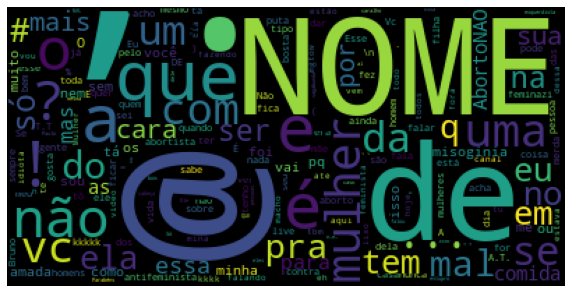


Number of features without pre-processing:  4131


In [ ]:
tokenized_df= df['comment'].apply(word_tokenize)
allWords_original, freq_original = plotWordCloud(tokenized_df)
features_original = list(freq_original.keys())[:]
print('\nNumber of features without pre-processing: ',len(features_original))

###Cleaning the dataset

In [ ]:
clean_tweets = df['comment'].apply(tweet_clean)
new_col = pd.DataFrame({'comment': clean_tweets})
df.update(new_col)
data_table.DataTable(df, num_rows_per_page=5)

,comment,date,keyword,source,userID_videoID,nº annotators,nº agree with label,ofens_clas_1,ofens_clas_2,ofens_clas_2,disc_clas_1,disc_clas_2,disc_clas_3,offensive,hate
0,vejo mulher antifeminista consigo pensar,2020-12-23 19:31:28,antifeminista,Twitter,386034034,3,3,0,0,0,0,0,0,0,0
1,ai amg garota saco antifeminista gordofobica...,2020-12-22 23:14:30,antifeminista,Twitter,1200867040774557700,3,3,0,0,0,0,0,0,0,0
2,cancelando t t cu casa 🥰 🤤 🥳,2020-12-28 20:00:39,thelma,Twitter,332579359,3,2,1,1,1,0,1,1,1,0
3,nunca abortonao,2020-12-30 18:46:47,#abortonao,Twitter,163015830,3,2,0,1,1,0,0,1,1,0
4,ctz nao estao 4 tipo ideia privilegio alug...,2020-12-28 20:06:41,thelma,Twitter,53777854,3,3,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,contar q gillete caro pra kct,2020-12-28T02:32:28Z,social arts,Youtube,kD_fsOer4co,3,3,0,0,0,0,0,0,0,0
719,todo dia podcast poderia entrevistar policial ...,2020-08-26T16:32:23Z,todo_dia_podcast_mgtow,Youtube,X316lRBL4qA,3,3,0,0,0,0,0,0,0,0
720,concordo pq quarto,2020-11-05T01:56:18Z,estupro,Youtube,qtY9Yj78sYo,3,2,1,1,1,1,1,0,1,0
721,maior vergonha alheia entrevista mulher verg...,2020-11-04T03:18:15Z,mariana_ferrer,Youtube,6rQ0uwUG1CQ,3,3,0,0,0,0,0,0,0,0


In [ ]:
#Tokenize the Data Frame
tokenized_base= df['comment'].apply(word_tokenize)
#Tokenize Hate Data Frame
hate_base = df.loc[df['hate']== 1]
tokenized_hate_base = hate_base['comment'].apply(word_tokenize)
#Tokenize No Hate Data Frame
no_hate_base = df.loc[df['hate']== 0]
tokenized_no_hate_base= no_hate_base['comment'].apply(word_tokenize)

###Word Clouds

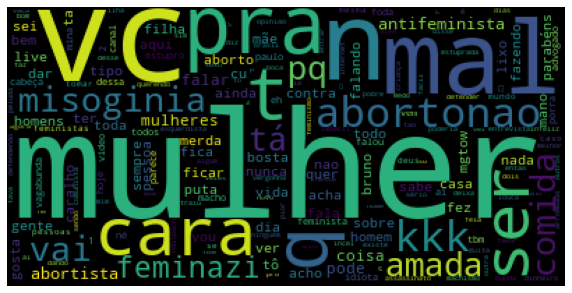

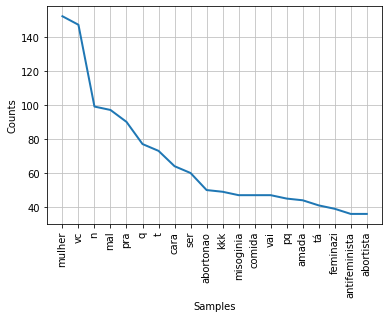


Number of features after pre-processing:  3347


In [ ]:
#Most frequent words in the dataframe excluding stopwords
allWords, freq = plotWordCloud(tokenized_base)
plotFrenquencies(freq)
print('\nNumber of features after pre-processing: ',len(freq))

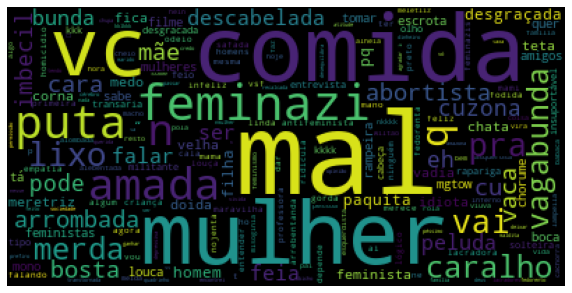

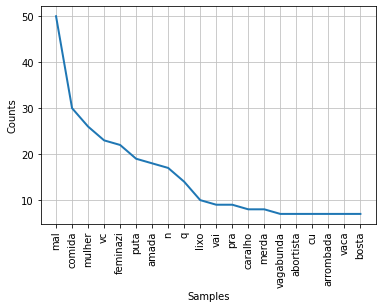

In [ ]:
#Most frequent words in the hate dataframe excluding stopwords
allWords_hate, freq_hate = plotWordCloud(tokenized_hate_base)
plotFrenquencies(freq_hate)

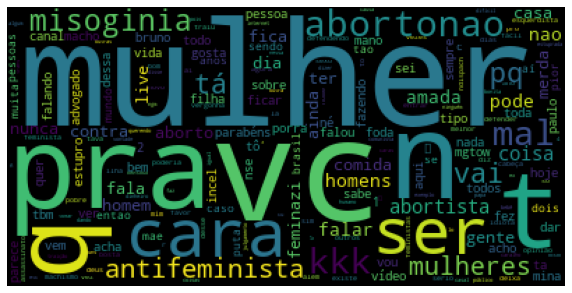

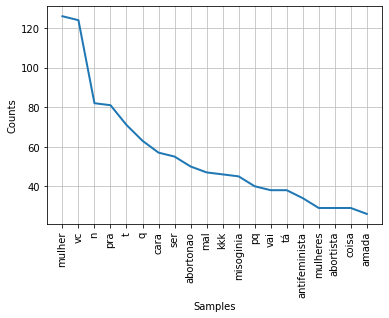

In [ ]:
#Most frequent words in the no hate dataframe excluding stopwords
allWords_no_hate, freq_no_hate = plotWordCloud(tokenized_no_hate_base)
plotFrenquencies(freq_no_hate)

#Bag of Words

In [ ]:
def extractNumericalBoW(frase, total_features_map):
  words = set(frase)
  word_features = {}

  for w in total_features_map:
    count = 0

    for word in words:
      if word == w:
        count = count+1

    word_features[w] = count

  return word_features

In [ ]:
#list with all the existing different words 
total_features_map = list(freq.keys())[:]

#list of labels
Y_data = [label for label in df[:]['hate']]
X_data = []

for i in range(len(allWords)):
  X_data.append((extractNumericalBoW(allWords[i], total_features_map), Y_data[i]))

In [ ]:
print("Final number of features: ", len(total_features_map))

Final number of features:  3347


#Classification

###Functions

In [ ]:
from sklearn.model_selection import StratifiedKFold

def TrainClassifierWithScore (kfold, X_data_np, Y_data_np, classifier_type):

  scoring = ['accuracy', 'average_precision', 'f1', 'precision', 'recall', 'roc_auc']

  cv = StratifiedKFold(n_splits = kfold, shuffle = True, random_state = 42)

  if classifier_type == 'svm_poly':
    classifier = SVC(kernel='poly', C=0.45, probability=True, gamma='auto', class_weight='balanced')
      
  elif classifier_type == 'svm_rbf':
    classifier = SVC(kernel='rbf', C=0.45, probability=True, gamma='auto', class_weight='balanced')

  elif classifier_type == 'svm_linear':
    classifier = SVC(kernel='linear', C=0.2, probability=True, gamma='auto', class_weight='balanced')

  elif classifier_type == 'naive_gaussiano':
    classifier = GaussianNB()

  elif classifier_type == 'naive_bernoulli':
    classifier = BernoulliNB(binarize = None)

  elif classifier_type == 'naive_multinomial':
    classifier = MultinomialNB()

  elif classifier_type == 'random_forest':
    classifier = RandomForestClassifier(n_estimators=100)

  results = cross_validate(estimator = classifier, X = X_data_np, y = Y_data_np, cv = cv, scoring = scoring, return_train_score = True)

  return results

def DictToArray(X_data):

  X_data_array = []
  Y_data_array = []

  for X in X_data:
    feature = []
    for feat in X[0].values():
      feature.append(feat)

    X_data_array.append(feature)
    Y_data_array.append(X[1])

  X_data_np = np.array(X_data_array)
  Y_data_np = np.array(Y_data_array, dtype = int)

  return X_data_np, Y_data_array

def printScoreTable(scores, kfold, classifier_type):
  print("\nClassifier:%s" % classifier_type)
  print("K:\tAcc.:\tPre:\tRec.:\tF1-S.:")
  mean_acc = 0
  mean_pre = 0
  mean_rec = 0
  mean_f1 = 0
  for i in range(kfold):
    mean_acc += (scores['test_accuracy'])[i]
    mean_pre += (scores['test_precision'])[i]
    mean_rec += (scores['test_recall'])[i]
    mean_f1 += (scores['test_f1'])[i]
    print("%i\t%.4f\t%.4f\t%.4f\t%.4f\t" % (i+1, scores['test_accuracy'][i], scores['test_precision'][i], scores['test_recall'][i], scores['test_f1'][i]))
  
  print("Mean\t%.4f\t%.4f\t%.4f\t%.4f\t" % (mean_acc/kfold, mean_pre/kfold, mean_rec/kfold, mean_f1/kfold))

###Search for the best parameters

In [ ]:
#transforming the data from dictionary to array format
X_data_np, Y_data_np = DictToArray(X_data)

In [ ]:
kfold = 5

scoring = ['accuracy', 'average_precision', 'f1', 'precision', 'recall', 'roc_auc']

cv = KFold(n_splits = kfold, shuffle = True, random_state = 42)

#SVM: searching for best parameters

svm_parameters = {
    'kernel': ['linear','poly','rbf'],
    'gamma': ['auto', 'scale'],
    'C': [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.7, 0.8],
    'class_weight' : ['balanced']
}

svm_grid = GridSearchCV(
    estimator = SVC(),
    param_grid = svm_parameters,
    cv = cv,
    scoring = scoring,
    refit =  'f1',
    verbose = 3
)

svm_grid.fit(X_data_np, Y_data_np)

#--------------------------------#

#Random Forest: searching for best parameters

parametros_forest = {
    'n_estimators': [100, 200, 300],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [80, 90, 100, 110],
    'min_samples_split'  : [2, 5, 8, 10],
    'min_samples_leaf' : [1, 3, 5]
}

grid_forest = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = parametros_forest,
    scoring = scoring,
    refit = 'f1',
    cv = 5,
    verbose = 3
)

grid_forest.fit(X_data_np, Y_data_np)

In [ ]:
print("Best svm F1 Score: ", svm_grid.best_score_)
print("Best svm Score Parameters: ", svm_grid.best_params_)

print("Best random forest F1 Score: ", grid_forest.best_score_)
print("Best random forest Score Parameters: ", grid_forest.best_params_)

Best svm F1 Score:  0.5968043057774788
Best svm Score Parameters:  {'C': 0.2, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}
Best random forest F1 Score:  0.4420646020646021
Best random forest Score Parameters:  {'criterion': 'gini', 'max_depth': 80, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
kfold = 5

#training linear SVM model
score_svm_linear = TrainClassifierWithScore(kfold, X_data_np, Y_data_np, 'svm_linear')
#training Random Forest model
score_forest = TrainClassifierWithScore(kfold, X_data_np, Y_data_np, 'random_forest')
#training Gaussian Naive Bayes model
score_naive_gaussiano = TrainClassifierWithScore(kfold, X_data_np, Y_data_np, 'naive_gaussiano')
#training Bernoulli Naive Bayes model
score_naive_bernoulli = TrainClassifierWithScore(kfold, X_data_np, Y_data_np, 'naive_bernoulli')
#training Multinomial Naive Bayes model
score_naive_multinomial = TrainClassifierWithScore(kfold, X_data_np, Y_data_np, 'naive_multinomial')

In [ ]:
#Print Score Table

#Linear SVM
printScoreTable(score_svm_linear, kfold, 'svm_linear')
#Random Forest
printScoreTable(score_forest, kfold, 'random_forest')
#Gaussian Naive Bayes
printScoreTable(score_naive_gaussiano, kfold, 'naive_bayes_gaussiano')
#Multinomial Naive Bayes
printScoreTable(score_naive_multinomial, kfold, 'naive_bayes_multi')
#Bernoulli Naive Bayes
printScoreTable(score_naive_bernoulli, kfold, 'naive_bayes_bernoulli')


Classifier:svm_linear
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.8897	0.5909	0.6500	0.6190	
2	0.8828	0.5882	0.5000	0.5405	
3	0.8276	0.3810	0.4000	0.3902	
4	0.8958	0.6000	0.6316	0.6154	
5	0.8889	0.5714	0.8000	0.6667	
Mean	0.8769	0.5463	0.5963	0.5664	

Classifier:random_forest
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.9034	0.7500	0.4500	0.5625	
2	0.8897	1.0000	0.2000	0.3333	
3	0.8483	0.4286	0.3000	0.3529	
4	0.9028	1.0000	0.2632	0.4167	
5	0.8819	0.5789	0.5500	0.5641	
Mean	0.8852	0.7515	0.3526	0.4459	

Classifier:naive_bayes_gaussiano
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.8000	0.3333	0.4500	0.3830	
2	0.8069	0.3462	0.4500	0.3913	
3	0.7793	0.2500	0.3000	0.2727	
4	0.8333	0.3684	0.3684	0.3684	
5	0.7778	0.3235	0.5500	0.4074	
Mean	0.7995	0.3243	0.4237	0.3646	

Classifier:naive_bayes_multi
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.7724	0.2903	0.4500	0.3529	
2	0.7793	0.2000	0.2000	0.2000	
3	0.8138	0.3158	0.3000	0.3077	
4	0.8194	0.3600	0.4737	0.4091	
5	0.7986	0.3636	0.6000	0.4528	
Mean	0.7967	0.3059	0.4047	0.3445	

Classifier:naive_bayes

#Training

### Splitting the dataset

In [ ]:
y_data = pd.Series(Y_data_np)

In [ ]:
from sklearn.model_selection import train_test_split
# 75% of the dataset -> train
x_train, x_test, y_train, y_test = train_test_split(X_data_np, y_data, random_state = 42, stratify = y_data)

In [ ]:
index_train = y_train.keys()
index_test = y_test.keys()

base_train = df.iloc[index_train]
base_test = df.iloc[index_test]

print('Hate label proportion in the train and test datasets:')
print('\nTrain dataset:\n')
print(base_train['hate'].value_counts())
print('\nTest dataset:\n')
print(base_test['hate'].value_counts())

Hate label proportion in the train and test datasets:

Train dataset:

0    468
1     74
Name: hate, dtype: int64

Test dataset:

0    156
1     25
Name: hate, dtype: int64


In [ ]:
print('Number of annotators that agree with the label:')
print('\nTrain dataset:\n')
print(base_train['nº agree with label'].value_counts())
print('\nTest dataset:\n')
print(base_test['nº agree with label'].value_counts())

Number of annotators that agree with the label:

Train dataset:

3    358
2    184
Name: nº agree with label, dtype: int64

Test dataset:

3    125
2     56
Name: nº agree with label, dtype: int64


###SVM

In [ ]:
#train with best parameters found at GridSearch
classifier_svm = SVC(kernel = 'linear', C = 0.2, probability = True, gamma = 'auto', class_weight = 'balanced')
classifier_svm.fit(x_train,y_train)

SVC(C=0.2, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
y_predict_svm_linear = classifier_svm.predict(x_test)
print("SVM: Confusion Matrix\n")
print(confusion_matrix(y_test, y_predict_svm_linear))

#F1-Score and Accuracy
from sklearn.metrics import f1_score
print("\nF1 Score: ", f1_score(y_test, y_predict_svm_linear))
from sklearn.metrics import accuracy_score
print("\nAccuracy: ", accuracy_score(y_test, y_predict_svm_linear))

SVM: Confusion Matrix

[[150   6]
 [  6  19]]

F1 Score:  0.76

Accuracy:  0.9337016574585635


In [ ]:
#splitting the test data by results: false positive, false negative, true positive, true negative
data = y_test.array

base_test['SVM result'] = ''

for i in range (len(data)):
  if data[i] == y_predict_svm_linear[i]:
    if data[i] == 1:
      base_test.loc[index_test[i], 'SVM result'] = 'TP'
    else:
      base_test.loc[index_test[i], 'SVM result'] = 'TN'
  if data[i] != y_predict_svm_linear[i]:
    if y_predict_svm_linear[i] == 1:
      base_test.loc[index_test[i], 'SVM result'] = 'FP'
    if y_predict_svm_linear[i] == 0:
      base_test.loc[index_test[i], 'SVM result'] = 'FN'

In [ ]:
TP_svm = base_test.loc[base_test['SVM result'] == 'TP']
TN_svm = base_test.loc[base_test['SVM result'] == 'TN']
FN_svm = base_test.loc[base_test['SVM result'] == 'FN']
FP_svm = base_test.loc[base_test['SVM result'] == 'FP']

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
#Saving dataframe at drive
TP_svm.to_csv('/drive/My Drive/MINA3_tp_svm.csv')
TN_svm.to_csv('/drive/My Drive/MINA3_tn_svm.csv')
FN_svm.to_csv('/drive/My Drive/MINA3_fn_svm.csv')
FP_svm.to_csv('/drive/My Drive/MINA3_fp_svm.csv')
base_test.to_csv('/drive/My Drive/MINA3_test_svm.csv')

###Random Forest

In [ ]:
#train with best parameters found at GridSearch
classifier_forest = RandomForestClassifier(n_estimators=100)
classifier_forest.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#Confusion Matrix
print("Random Forest: Confusion Matrix\n")
y_predict_forest = classifier_forest.predict(x_test)
print(confusion_matrix(y_test, y_predict_forest))

#F1-Score and Accuracy
print("\nF1 Score: ", f1_score(y_test, y_predict_forest))
print("\Acurácia: ", accuracy_score(y_test, y_predict_forest))

Random Forest: Confusion Matrix

[[155   1]
 [ 17   8]]

F1 Score:  0.47058823529411764
\Acurácia:  0.9005524861878453


In [ ]:
#splitting the test data by results: false positive, false negative, true positive, true negative

data = y_test.array

base_test['Forest result'] = ''

for i in range (len(data)):
  if data[i] == y_predict_forest[i]:
    if data[i] == 1:
      base_test.loc[index_test[i], 'Forest result'] = 'TP'
    else:
      base_test.loc[index_test[i], 'Forest result'] = 'TN'
  if data[i] != y_predict_forest[i]:
    if y_predict_forest[i] == 1:
      base_test.loc[index_test[i], 'Forest result'] = 'FP'
    if y_predict_forest[i] == 0:
      base_test.loc[index_test[i], 'Forest result'] = 'FN'

In [ ]:
TP_forest = base_test.loc[base_test['Forest result'] == 'TP']
TN_forest = base_test.loc[base_test['Forest result'] == 'TN']
FN_forest = base_test.loc[base_test['Forest result'] == 'FN']
FP_forest = base_test.loc[base_test['Forest result'] == 'FP']

In [ ]:
#Saving dataframe at drive
TP_forest.to_csv('/drive/My Drive/tp_forest.csv')
TN_forest.to_csv('/drive/My Drive/tn_forest.csv')
FN_forest.to_csv('/drive/My Drive/fn_forest.csv')
FP_forest.to_csv('/drive/My Drive/fp_forest.csv')
base_test.to_csv('/drive/My Drive/base_test.csv')